## Astronomical catalogues

*PhotUtils, VizieR queries, Simbad queries, coordinate projections*

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astropy.io import fits

%matplotlib inline

*Time for upgrades!* This notebook relies on two modules that are likely absent from your Python installation: *AstroQuery* and *PhotUtils*. We will need the former to query star catalogues and the latter to perform automated source extraction. On *Windows*, head to your **Conda prompt** (you may need to open a second instance of the prompt if you already have one running but it is not interactive). On *Mac OS* or *Linux* based systems, the regular terminal with correctly configured environment variables will do. Once you get there, run the following:

```
conda install -c astropy photutils
```

The installation may take a few minutes. At some point, the terminal may ask if you want to proceed:

```
Proceed ([y]/n)?
```

you will need to type `y` and hit `ENTER`. Eventually, the package installer should terminate with `COMPLETE` and hand you back the control. Make sure the output does not report any critical errors.

Next, we need to install AstroQuery. Similarly, run the following in your terminal:

```
pip install astroquery
```

<div class="alert alert-info">
    Before you halt your terminal session, copy its entire output and save it somewhere. If the installation fails, I will need to see this output to help you troubleshoot. On <i>Windows</i>, you can select text in the Conda prompt with your mouse and copy with <code>ENTER</code>. On <i>Linux</i> and <i>Mac OS</i>, the usual hotkeys should work.
</div>

Now, restart your kernel (Kernel->Restart) and run the cell below. With some luck, it should not produce any errors. If it does, check the terminal output for errors once more. Try searching the web for the error descriptions first and get in touch with me if it doesn't help.

In [5]:
# Automated source extraction
from photutils import DAOStarFinder

# Simbad queries
from astroquery.simbad import Simbad

# VizieR queries
from astroquery.vizier import Vizier

# Coordinates transformations and units
from astropy.coordinates import SkyCoord
import astropy.units as u

## The test image

This notebook will be dealing with an image of the open cluster, [NGC 1502](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=NGC+1502&submit=SIMBAD+search) acquired on 04/05/2017 at [University College London Observatory](https://en.wikipedia.org/wiki/UCL_Observatory). The image can be downloaded from GitHub. The UCLO telescope is very different from Nickel. Therefore, you will have to make significant changes to the code presented in this notebook before it can be applied to Nickel data.

The table below summarizes the most crucial information about the system used to acquire the test image. You will need to research the same parameters for Nickel. Some of this information can be extracted from FITS headers, but be advised that some of those headers may not be listed in the Nickel data and others may be named differently.

<table width="80%">
<tr><td><b>Parameter</b></td><td><b>Value</b></td><td><b>Relevant FITS header</b></td></tr>
<tr><td>Telescope</td><td>Celestron 14</td><td><code>OBSERVAT</code></td></tr>
<tr><td>CCD</td><td>SBIG STL-6303</td><td><code>INSTRUME</code></td></tr>
<tr><td>Aperture</td><td>350 mm</td><td><code>APTDIA</code></td></tr>
<tr><td>Focal length</td><td>4300 mm</td><td><code>FOCALLEN</code></td></tr>
<tr><td>Pixel size (after binning)</td><td>18 μm</td><td><code>XPIXSZ</code>, <code>YPIXSZ</code></td></tr>
<tr><td>Binning</td><td>2x2</td><td><code>XBINNING</code>, <code>YBINNING</code></td></tr>
<tr><td>CCD size (after binning)</td><td>1536x1024</td><td><code>NAXIS1</code>, <code>NAXIS2</code></td></tr>
<tr><td>Field of view</td><td>30x15 arcmin</td><td>No FITS header, but you can calculate it</td></tr>
</table>

Let's open the image and see what it looks like...

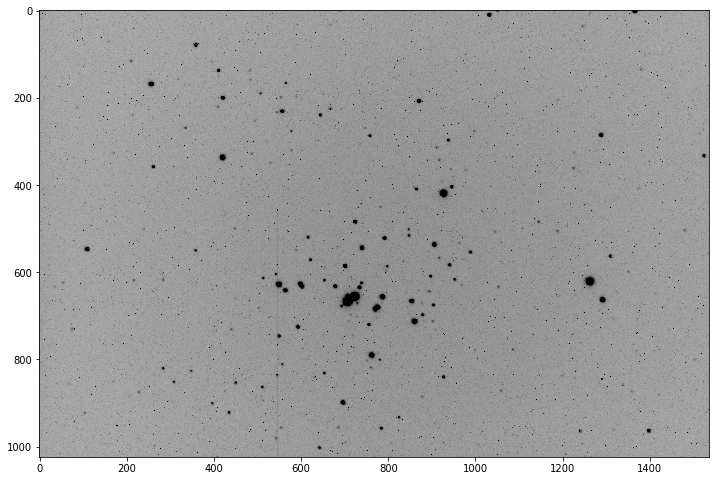

In [6]:
image = 'NGC_1502.fits'              # Point this to your file system

h = fits.open(image)
data = h[0].data * 1.0
h.close()

vmin = np.mean(data) - np.std(data)
vmax = np.mean(data) + np.std(data)
plt.figure(figsize = [12, 9])
plt.imshow(data, vmin = vmin, vmax = vmax, cmap = 'Greys')

The image shows a hundred or so bright stars that can be extracted. The stars in the core of the cluster are perhaps too close together to be extracted reliably. I will now perform source extraction on this image using an opensource algorithm called [DAOPHOT](http://adsabs.harvard.edu/abs/1987PASP...99..191S), developed by Peter Stetson (Dominion Astrophysical Observatory, DAO). **Of course, you will be expected to implement your own source extraction algorithm.** DAOPHOT, alongside many other important photometric algorithms, is available through *PhotUtils*.

DAOPHOT found 73 stars


C:\Users\Roman\AppData\Roaming\Python\Python27\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


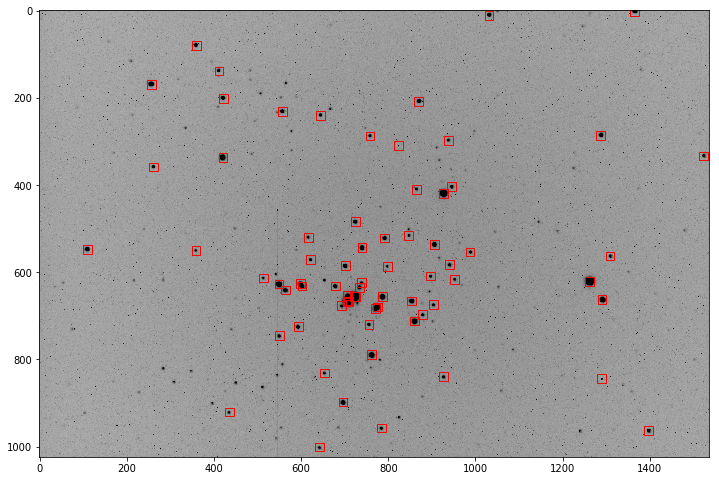

In [7]:
# First, we need to create a star finder object. "fwhm = 5.0" means "ignore all objects with FWHM < 5 pixels"
# "threshold = 2 * np.std(data)" means "ignore all objects fainter than 2 * np.std(data)
# Feel free to experiment with these settings to see if you can pick out more stars, but do not push those far enough
# to trigger misidentifications!
daofind = DAOStarFinder(fwhm = 5.0, threshold = 2 * np.std(data))

# Apply a (very) rough correction for bias and sky brightness
data_corrected = data - np.median(data)

# Run DAOPHOT! (yes, it is just one line of code!) 
sources = daofind(data_corrected)


print "DAOPHOT found {} stars".format(len(sources))

# Plot the results
plt.figure(figsize = [12, 9])
plt.imshow(data, vmin = vmin, vmax = vmax, cmap = 'Greys')
for i, source in enumerate(sources):
    x = source["xcentroid"]
    y = source["ycentroid"]
    plt.axes().add_patch(patches.Rectangle([x - 10, y - 10], 20, 20, fill=False, color = 'r'))

## Simbad

Next, we need to query the stars we found from a star catalogue to get their celestial coordinates (RA and Dec). Before we can do that, we need to know which part of the sky we are looking at. Some telescopes will save this data in the FITS headers. For example,

In [8]:
h = fits.open(image)
ra_center     = h[0].header["RA"]
dec_center    = h[0].header["DEC"]
h.close()

print "RA:", ra_center
print "Dec:", dec_center

RA: 04 07 44.39
Dec: +62 22 03.0


Yet, those headers may be absent or worse, present and incorrect (*hint: this may be the case with some of the Nickel data*). Fortunately, we know what the telescope was looking at - the open cluster NGC 1502. Now we merely need to know the coordinates of this cluster.

An enormous amount of astronomical data, such as object coordinates and magnitudes, has been measured before and is publicly available through thousands of astronomical catalogues. Navigating this maze could be a nightmare if not for the [Centre de Données astronomiques de Strasbourg](http://cdsweb.u-strasbg.fr/) (aka CDS), who stand behind the most important and widely used astronomical software packages. In this notebook, we are specifically interested in two of their projects: [Simbad](http://simbad.u-strasbg.fr/) and [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR).

* **SIMBAD (Set of Identifications, Measurements and Bibliography for Astronomical Data)** is a database of roughly 10 million stars and extragalactic objects, compiled from thousands of catalogues. When querying Simbad, the user only needs to choose the desired object. Simbad will automatically aggregate data from the relevant catalogues to display the most accurate information available about the chosen object in a standard uniform format. Nonetheless, Simbad will always provide bibliographic references for every value listed in case they need to be traced back to their origin.

* **VizieR** is a more low-level aggregator of astronomical catalogues, allowing complex queries. One can use VizieR to find all objects in a certain part of the sky satisfying given requirements. Users may choose the catalogue or allow VizieR to search all available catalogues.

*AstroPy* can query both Simbad and VizieR via its submodule, *AstroQuery*. First, let's use Simbad to find the coordinates of NGC 1502.

In [9]:
# The most basic Simbad query requires only one line of code:
result_table = Simbad.query_object('NGC 1502')

# Interpret the result
if result_table is None:
    print "Could not resolve this identifier ;("
else:
    ra_center  = result_table["RA"][0]            # [0] because sometimes Simbad finds multiple objects.
    dec_center = result_table["DEC"][0]
    print "RA:", ra_center
    print "Dec:", dec_center

RA: 04 07 50
Dec: +62 19.9


The units of the above output follow the standard convention. I.e., the RA is listed as `hh mm ss` in units of **time**, while the Dec is listed as `dd mm ss.s` in units of **arc**. There are 24 hours of **time** in a circle, each divided into 60 minutes of **time**, each divided into 60 seconds of **time**. There are 360 degrees of **arc** in a circle, each divided into 60 minutes of **arc**, each divided into 60 seconds of **arc**.
<br><br>

<div class="alert alert-warning">
    Minutes of arc are 15 times smaller than minutes of time and seconds of arc are 15 times smaller than seconds of time. All of those units, including "units of time", measure angles in this context, not time.
</div>

## SkyCoord

There are many ways to represent celestial coordinates (equatorial, ecliptic, galactic etc) and it can be done through many different systems of units (units of time, units of arc, decimal degrees, radians etc). You may be glad to know that *AstroPy* implements a submodule called `astropy.coordinates` that can take care of most of this housekeeping for us:

In [10]:
# First, we need to create a coordinates object
# In this case, we do so by specifying RA and Dec, but it can also be done in any other system of coordinates
# "unit = (u.hour, u.deg)" tells AstroPy that our RA is in units of time and our Dec is in units of arc
# "frame='icrs'" means equatorial coordinates (International Coordinate Reference System)
center = SkyCoord(ra = ra_center, dec = dec_center, unit = (u.hour, u.deg), frame='icrs')

# Now we can get our coordinates back in any units we need
print center.ra.deg             # RA in decimal degrees of arc
print center.dec.hour           # Dec in decimal hours of time
print center.ra.arcminute       # RA in decimal minutes of arc

61.9583333333
4.15544444444
3717.5


The module is also able to convert coordinate systems, simulate equinox precession and much more. Some of its more advanced features will be covered later in the course. Most importantly, the coordinates object is the format expected by both Simbad and VizieR.

## VizieR

It is time to query VizieR to get the coordinates of the stars in the test image. In this lab, we will use VizieR to query a specific catalogue designated as *USNO-B1* (United States Naval Observatory). A detailed description of the catalogue is available on the [VizieR website](http://cdsarc.u-strasbg.fr/ftp/I/284/ReadMe).

The catalogue goes down to 21st magnitude stars. This limit is significantly dimmer than we need, so we will have to set our query to limit the results by magnitude. The catalogue lists two different magnitudes through the `R` filter in the columns named `R1mag` and `R2mag`. For our purposes, it does not matter which of those we use.

In [11]:
# First, create a VizieR object. From the start, we tell VizieR that we do not want stars dimmer than 13.0
my_vizier = Vizier(column_filters = {"R2mag" : "<13.0"})

# By default, VizieR will limit the result to 50 stars. We change the limit to "-1" meaning "show everything you have"
# This is a dangerous setting, since some queries may return enormous amounts of data. In our case, however, only a small
# part of the sky is being queried, heavily limited by magnitude. We should be safe.
my_vizier.ROW_LIMIT = -1

# Run the query. We are requesting the part of the sky defined by the previously created coordinates object (center).
# width = "60m", height = "60m" specify the size of the region we need. This is larger than the field of view of the telescope
# since our coordinates may not be perfectly placed in the centre of the frame.
# "catalog = "USNO-B1" tells VizieR which catalogue we want. This could be a list of multiple catalogues.
result_table = my_vizier.query_region(center, width = "60m", height = "60m", catalog = "USNO-B1")

print "Total number of objects retrieved:", len(result_table[0])
print "Column names:", result_table[0].keys()

Total number of objects retrieved: 359
Column names: ['USNO-B1.0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000', 'Epoch', 'pmRA', 'pmDE', 'Ndet', 'B1mag', 'R1mag', 'B2mag', 'R2mag', 'Imag']


As can be seen among the column names, VizieR gave us coordinates in `J2000`. It has been almost 20 years since and some of the stars may have moved. Fortunately, the catalogue also lists the speeds at which these stars move: `pmRA` and `pmDE` stand for "proper motion in RA" and "proper motion in Dec", where "proper motion" means the intrinsic motion of the star ("proper" as in "a property of"; there is no such thing as "improper" motion).

We will need to use this information to "bring our stars up to date", bearing the following in mind:

* Proper motions are given in milliseconds of arc per year, while the coordinates are given in degrees of arc.
* Due to the spherical projection of celestial coordinates, the proper motion in RA will need to be corrected by $\cos(\delta)$, where $\delta$ is the declination (intuitively, units of RA get smaller as we approach celestial poles).

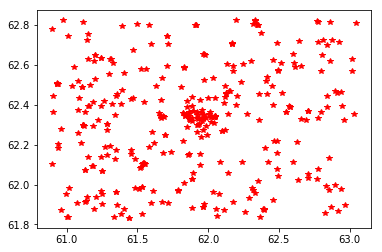

In [12]:
ra_cat     = np.array(result_table[0]["RAJ2000"])
dec_cat    = np.array(result_table[0]["DEJ2000"])
pm_ra      = np.array(result_table[0]["pmRA"])
pm_dec     = np.array(result_table[0]["pmDE"])
mag        = np.array(result_table[0]["R2mag"])


epoch = 2017.0   # The test image was taken in 2017. Hence, we will need coordinates in J2017. Strictly speaking
                 # this should be a fractional number, but most stars do not move fast enough to make the difference matter.

# Convert the units of pmDec from mas/yr to deg/yr
pm_dec = pm_dec / 1000.0 / 3600.0
# Same for RA, but with the cos(dec) correction. Note, np.cos() expects radians!
pm_ra  = pm_ra / 1000.0 / 3600.0 / np.cos(dec_cat * np.pi / 180.0)

# Move the stars
ra_cat  += (epoch - 2000.0) * pm_ra
dec_cat += (epoch - 2000.0) * pm_dec

# Needs labels!
plt.plot(ra_cat, dec_cat, 'r*')

## Standard coordinates

The catalogue coordinates in the plot above are in RA and Dec, while the coordinates given to us by the source extraction are $x$ and $y$ pixel positions. The conversion procedure is described in detail in the experiment handout and involves two steps. First, the coordinates must be projected from the celestial sphere onto a flat CCD plate. Denoting the celestial coordinates with $\alpha$ and $\delta$ (RA and Dec respectively) and the rectangular coordinates with $X$ and $Y$, the relevant formulae are:

$$X=-\frac{\cos(\delta)\sin(\alpha - \alpha_0)}{\cos(\delta_0)\cos(\delta)\cos(\alpha - \alpha_0) + \sin(\delta_0)\sin(\delta)}$$

$$Y=-\frac{\sin(\delta_0)\cos(\delta)\cos(\alpha - \alpha_0) - \cos(\delta_0)\sin(\delta)}{\cos(\delta_0)\cos(\delta)\cos(\alpha - \alpha_0) + \sin(\delta_0)\sin(\delta)}$$

where $\alpha_0$ and $\delta_0$ are some reference RA and Dec, whose pixel positions are known. In our case, we can use the center of the field (currently stored in `center`).

In [13]:
def sin(angle):
    """ Implementation of np.sin() in degrees """
    return np.sin(angle * np.pi / 180.0)

def cos(angle):
    """ Implementation of np.cos() in degrees """
    return sin(angle + 90)



denominator = cos(center.dec.deg) * cos(dec_cat) * cos(ra_cat - center.ra.deg) + sin(center.dec.deg) * sin(dec_cat)
X = - cos(dec_cat) * sin(ra_cat - center.ra.deg) / denominator
Y = - (sin(center.dec.deg) * cos(dec_cat) * cos(ra_cat - center.ra.deg) - cos(center.dec.deg) * sin(dec_cat)) / denominator

$X$ and $Y$ undo the spherical distortion, but they are **not** pixel positions just yet. $X$ and $Y$ are related to the pixel positions, $x$ and $y$, through unknown linear transformations (such as scaling and rotation), determined by the so-called plate constants that need to be determined for every imaging system. Later in the course, we will use statistical optimization to find the exact values of those constants. For now, we will compute $x$ and $y$ by assuming an *ideal* system, i.e. one where $X$ and $Y$ can be mapped to $x$ and $y$ using the formulae below:

$$x = f \frac{X}{p} + x_0$$
$$y = f \frac{Y}{p} + y_0$$

Here $x_0$ and $y_0$ are the pixel positions corresponding to $\alpha_0$ and $\delta_0$ (in our case, again, the centre of the frame). $p$ is the pixel size and $f$ is the focal length of the imaging system.

(0, 1024L)

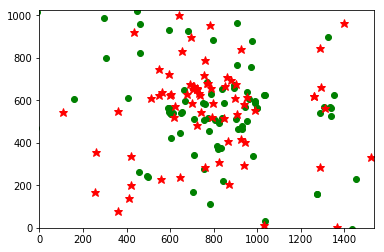

In [14]:
# From the table (perhaps should use FITS headers instead?)
f = 4300    # in mm
p = 18e-3   # in mm

x = f * (X / p) + np.shape(data)[1] / 2.0
y = f * (Y / p) + np.shape(data)[0] / 2.0

plt.plot(x, y, 'go')
plt.plot(sources['xcentroid'], sources['ycentroid'], 'r*', ms = 9)

plt.xlim(0, np.shape(data)[1])
plt.ylim(0, np.shape(data)[0])

The plot above does not appear to be a good match of the catalogue to the sky. This is because our system is not *ideal*. First and foremost, the field in the FITS file is vertically inverted. Second, the coordinates we assumed to be the centre of the field are the coordinates of the open cluster retrieved from Simbad, which may not actually be in the centre.

We can invert and slightly translate the field manually to achieve a better match:

(0, 1024L)

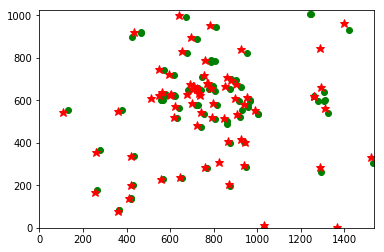

In [15]:
# Vertical inversion
x_manual = x
y_manual = -y

# Manual translation
x_manual -= 30
y_manual += 1164

plt.plot(x_manual, y_manual, 'go')
plt.plot(sources['xcentroid'], sources['ycentroid'], 'r*', ms = 9)

plt.xlim(0, np.shape(data)[1])
plt.ylim(0, np.shape(data)[0])

This result is, perhaps, better, but still clearly demonstrates that the field is rotated with respect to the catalogue and, possibly, has other distortions too that call for a proper statistical estimation of the plate constants.